In [4]:
import warnings

warnings.filterwarnings("ignore")  # ignore all warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # ignore deprecation warnings

# Importing Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from IPython.display import Image

# Data Preprocessing

In [6]:
dataset_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/" # For Kaggle notebooks. If you run locally, point this line to the CIFAKE directory

In [7]:
img_height = 32
img_width = 32
batch_size = 500

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/train",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/test",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)



Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [12]:
class_names = train_ds.class_names
print(class_names)

['FAKE', 'REAL']


# Model Building

In [13]:
val_true_classes = np.concatenate([y for x, y in val_ds], axis = 0)  # Get true labels
class_names = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True) 

# CNN

In [14]:
# Building a Simple CNN model
SimpleCNN_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the Simple CNN model
SimpleCNN_model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)



In [15]:
# Train the Simple CNN model
print("Starting training with Simple CNN...")
SimpleCNN_model_history = SimpleCNN_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    verbose=1,
    callbacks=[early_stopping]
)
print("Simple CNN training finished.")



Starting training with Simple CNN...
200/200 [==============================] - 45s 208ms/step - loss: 0.9276 - accuracy: 0.6899 - precision_1: 0.6889 - recall_1: 0.6927 - val_loss: 0.4314 - val_accuracy: 0.7979 - val_precision_1: 0.8032 - val_recall_1: 0.7890
Simple CNN training finished.


In [16]:
# Evaluate the model on the test dataset
val_loss_SimpleCNN, val_accuracy_SimpleCNN, val_precision_SimpleCNN, val_recall_SimpleCNN = SimpleCNN_model.evaluate(val_ds)


40/40 [==============================] - 4s 88ms/step - loss: 0.4314 - accuracy: 0.7979 - precision_1: 0.8032 - recall_1: 0.7890


# RESNET50

In [17]:
# Building the Transfer Learning model using ResNet50
ResNet_base_model = tf.keras.applications.ResNet50(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
ResNet_base_model.trainable = True

# Create a new model on top of the ResNet50 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = ResNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
ResNet_model = tf.keras.Model(inputs, outputs)

# Compile the model
ResNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


94765736/94765736 [==============================] - 0s 0us/step


In [18]:
# Train the Transfer Learning model
print("Starting training with Transfer Learning using ResNet50...")
ResNet_model_history = ResNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 1,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using ResNet50...
200/200 [==============================] - 69s 155ms/step - loss: 2.2579 - accuracy: 0.9101 - precision_2: 0.9090 - recall_2: 0.9113 - val_loss: 1.4298 - val_accuracy: 0.8188 - val_precision_2: 0.9947 - val_recall_2: 0.6409
Transfer Learning training finished.


In [19]:
# Evaluate the model on the test dataset
val_loss_ResNet, val_accuracy_ResNet, val_precision_ResNet, val_recall_ResNet = ResNet_model.evaluate(val_ds)


40/40 [==============================] - 4s 89ms/step - loss: 1.4298 - accuracy: 0.8188 - precision_2: 0.9947 - recall_2: 0.6409


# VCG16

In [20]:
# Building the Transfer Learning model using VGG16
VGG_base_model = tf.keras.applications.VGG16(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
VGG_base_model.trainable = True

# Create a new model on top of the VGG16 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = VGG_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
VGG_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
VGG_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)



58889256/58889256 [==============================] - 0s 0us/step


In [21]:
print("Starting training with Transfer Learning using VGG16...")
VGG_model_history = VGG_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 1,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using VGG16...
200/200 [==============================] - 36s 119ms/step - loss: 1.4269 - accuracy: 0.7880 - precision_3: 0.7670 - recall_3: 0.8272 - val_loss: 0.7598 - val_accuracy: 0.7686 - val_precision_3: 0.6860 - val_recall_3: 0.9908
Transfer Learning training finished.


In [22]:
# Evaluate the model on the test dataset
val_loss_VCG, val_accuracy_VCG, val_precision_VCG, val_recall_VCG = VGG_model.evaluate(val_ds)

40/40 [==============================] - 4s 84ms/step - loss: 0.7598 - accuracy: 0.7686 - precision_3: 0.6860 - recall_3: 0.9908


# EfficientNetV2B0

In [23]:
# Building the Transfer Learning model using EfficientNetV2B0
EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the EfficientNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = EfficientNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
EfficientNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
EfficientNet_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


24274472/24274472 [==============================] - 0s 0us/step


In [24]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using EfficientNet...")
EfficientNet_model_history = EfficientNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 1,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using EfficientNet...
200/200 [==============================] - 95s 259ms/step - loss: 1.4107 - accuracy: 0.9379 - precision_4: 0.9378 - recall_4: 0.9379 - val_loss: 0.3709 - val_accuracy: 0.9611 - val_precision_4: 0.9739 - val_recall_4: 0.9476
Transfer Learning training finished.


In [25]:
# Evaluate the model on the test dataset
val_loss_EffNet, val_accuracy_EffNet, val_precision_EffNet, val_recall_EffNet = EfficientNet_model.evaluate(val_ds)



40/40 [==============================] - 8s 158ms/step - loss: 0.3709 - accuracy: 0.9611 - precision_4: 0.9739 - recall_4: 0.9476


# MobileNetV3

In [26]:
# Building the Transfer Learning model using MobileNetV3
MobileNet_base_model = tf.keras.applications.MobileNetV3Small(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
MobileNet_base_model.trainable = True

# Create a new model on top of the MobileNet base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = MobileNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
x = Dense(64, activation = 'relu')(x)
outputs = Dense(1, activation = 'sigmoid')(x)
MobileNet_model = tf.keras.Model(inputs, outputs)

# Compile the Transfer Learning model
MobileNet_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)



4334752/4334752 [==============================] - 0s 0us/step


In [27]:
# Finally, train the Transfer Learning model
print("Starting training with Transfer Learning using MobileNet...")
MobileNet_model_history = MobileNet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 1,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using MobileNet...
200/200 [==============================] - 66s 188ms/step - loss: 0.9234 - accuracy: 0.8676 - precision_5: 0.8552 - recall_5: 0.8850 - val_loss: 0.2475 - val_accuracy: 0.9172 - val_precision_5: 0.9621 - val_recall_5: 0.8685
Transfer Learning training finished.


In [28]:
# Evaluate the model on the test dataset
val_loss_MobileNet, val_accuracy_MobileNet, val_precision_MobileNet, val_recall_MobileNet = MobileNet_model.evaluate(val_ds)


40/40 [==============================] - 8s 159ms/step - loss: 0.2475 - accuracy: 0.9172 - precision_5: 0.9621 - recall_5: 0.8685


# Comparison on Models

In [29]:
# Evaluating and printing metrics for all models
print(f"ResNet50 - Accuracy: {val_accuracy_ResNet}, Precision: {val_precision_ResNet}, Recall: {val_recall_ResNet}")
print(f"VGG16 - Accuracy: {val_accuracy_VCG}, Precision: {val_precision_VCG}, Recall: {val_recall_VCG}")
print(f"EfficientNetV2B0 - Accuracy: {val_accuracy_EffNet}, Precision: {val_precision_EffNet}, Recall: {val_recall_EffNet}")
print(f"MobileNetV3 - Accuracy: {val_accuracy_MobileNet}, Precision: {val_precision_MobileNet}, Recall: {val_recall_MobileNet}")
print(f"Simple CNN - Accuracy: {val_accuracy_SimpleCNN}, Precision: {val_precision_SimpleCNN}, Recall: {val_recall_SimpleCNN}")


ResNet50 - Accuracy: 0.8187500238418579, Precision: 0.9947229623794556, Recall: 0.6409000158309937
VGG16 - Accuracy: 0.7686499953269958, Precision: 0.6860070824623108, Recall: 0.9908000230789185
EfficientNetV2B0 - Accuracy: 0.9610999822616577, Precision: 0.9738951921463013, Recall: 0.9476000070571899
MobileNetV3 - Accuracy: 0.9171500205993652, Precision: 0.9621136784553528, Recall: 0.8684999942779541
Simple CNN - Accuracy: 0.7978500127792358, Precision: 0.8032169342041016, Recall: 0.7889999747276306


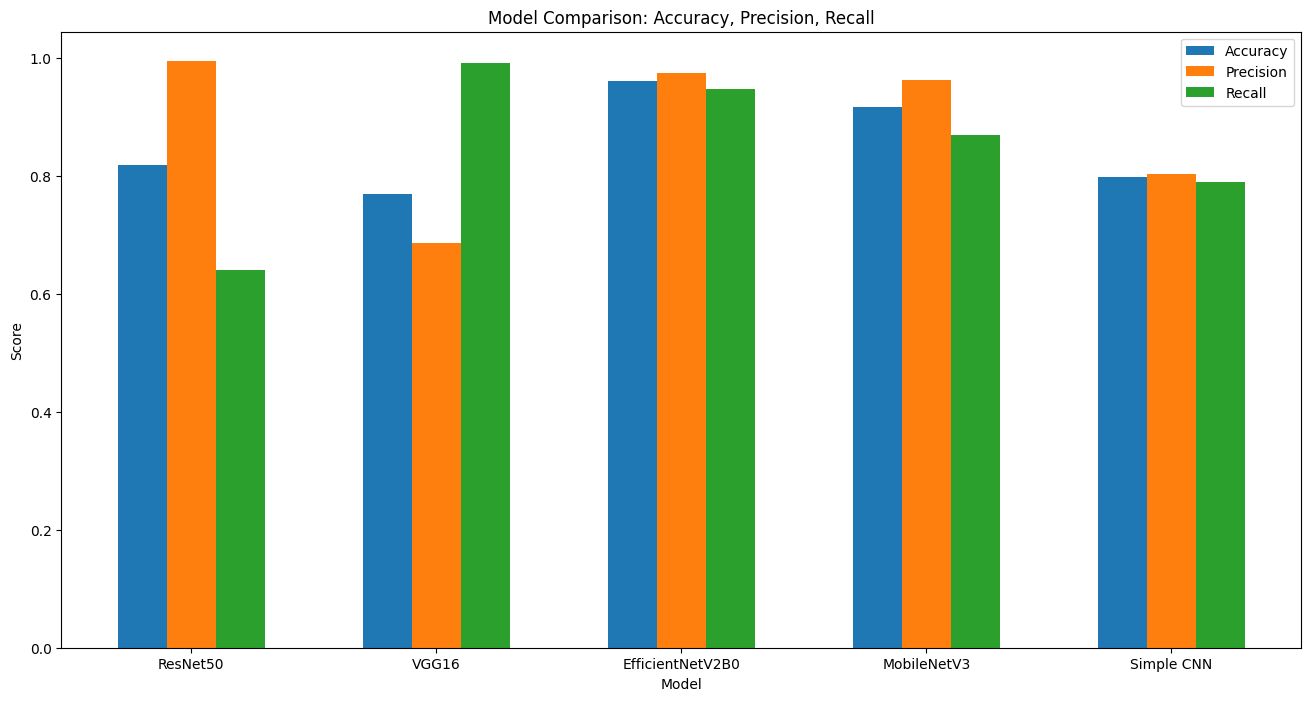

In [30]:
# Plot accuracy, precision, and recall of all models
model_names = ["ResNet50", "VGG16", "EfficientNetV2B0", "MobileNetV3", "Simple CNN"]
accuracy_scores = [val_accuracy_ResNet, val_accuracy_VCG, val_accuracy_EffNet, val_accuracy_MobileNet, val_accuracy_SimpleCNN]
precision_scores = [val_precision_ResNet, val_precision_VCG, val_precision_EffNet, val_precision_MobileNet, val_precision_SimpleCNN]
recall_scores = [val_recall_ResNet, val_recall_VCG, val_recall_EffNet, val_recall_MobileNet, val_recall_SimpleCNN]

x = np.arange(len(model_names))

plt.figure(figsize=(16, 8))

plt.bar(x - 0.2, accuracy_scores, 0.2, label='Accuracy')
plt.bar(x, precision_scores, 0.2, label='Precision')
plt.bar(x + 0.2, recall_scores, 0.2, label='Recall')

plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy, Precision, Recall")
plt.xticks(x, model_names)
plt.legend(loc='best')

plt.show()


# Making Predections

1/1 [==============================] - 0s 18ms/step
ResNet50 Prediction: FAKE
VGG16 Prediction: FAKE
EfficientNetV2B0 Prediction: FAKE
MobileNetV3 Prediction: FAKE
Simple CNN Prediction: FAKE


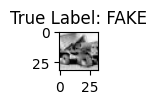

In [36]:
# Select a sample image from the validation dataset
for images, labels in val_ds.take(1):  # Take a batch of images
    img_array = images[0].numpy()  # Take the first image from the batch
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match input shape

# Make predictions with each model, including Simple CNN
pred_resnet = ResNet_model.predict(img_array)
pred_vgg = VGG_model.predict(img_array)
pred_effnet = EfficientNet_model.predict(img_array)
pred_mobilenet = MobileNet_model.predict(img_array)
pred_simplecnn = SimpleCNN_model.predict(img_array)

# Convert predictions to "REAL" or "FAKE"
threshold = 0.5
pred_resnet_label = "REAL" if pred_resnet[0][0] >= threshold else "FAKE"
pred_vgg_label = "REAL" if pred_vgg[0][0] >= threshold else "FAKE"
pred_effnet_label = "REAL" if pred_effnet[0][0] >= threshold else "FAKE"
pred_mobilenet_label = "REAL" if pred_mobilenet[0][0] >= threshold else "FAKE"
pred_simplecnn_label = "REAL" if pred_simplecnn[0][0] >= threshold else "FAKE"

# Print out the predictions with titles
print(f"ResNet50 Prediction: {pred_resnet_label}")
print(f"VGG16 Prediction: {pred_vgg_label}")
print(f"EfficientNetV2B0 Prediction: {pred_effnet_label}")
print(f"MobileNetV3 Prediction: {pred_mobilenet_label}")
print(f"Simple CNN Prediction: {pred_simplecnn_label}")

# Display the image, reduced by around 50% in size
plt.figure(figsize=(0.5, 0.5))  # Reduce size by 50% (from 8x8 to 4x4)
plt.imshow(images[0].numpy().astype("uint8"))
plt.title(f"True Label: {class_names[labels[0]]}")
plt.show()
